In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import seaborn as sns
from collections import OrderedDict
sns.set()

# Preprocessing
from sklearn.preprocessing import QuantileTransformer
# Algorithms
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA

from scipy.cluster.hierarchy import dendrogram

DATA_DIR = Path('../data')
PROC_DIR = Path(DATA_DIR / 'original/processed')
OUT_DIR = Path('./out/pca')

if not OUT_DIR.exists():
    Path.mkdir(OUT_DIR)
    

flow_columns = ['R [Rsun]', 'B [G]', 'alpha [deg]']

# Helper Functions

In [54]:
def plot_km_results(cluster_count, labels, series):
    plot_count = math.ceil(math.sqrt(cluster_count))
    fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))
    fig.suptitle('Clusters')
    row_i=0
    column_j=0
    # For each label there is,
    # plots every series with that label
    for label in set(labels):
        cluster = []
        for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot(series[i],c="gray",alpha=0.4)
                cluster.append(series[i])
        if len(cluster) > 0:
            axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
        axs[row_i, column_j].set_title("Cluster "+str(row_i*plot_count+column_j))
        column_j+=1
        if column_j%plot_count == 0:
            row_i+=1
            column_j=0
    plt.tight_layout()
    plt.show()    
    
def plot_unscaled_clusters(labels, nclusters, flows_dict, columns, save_path=None):
    """Plot cluster of the original data (not scaled)"""  
    
    fig, axs = plt.subplots(nrows=nclusters, ncols=len(columns), figsize=(5*len(columns), 5*nclusters))
    for idx, flow in enumerate(flows_dict.values()):
        for col_pos, col in enumerate(columns):
            axs[(labels[idx], col_pos)].plot(flow[col], linewidth=0.5)
            axs[(labels[idx], col_pos)].set(ylabel=col, title=f'Cluster {labels[idx]}')
            
    plt.tight_layout()
    
    if save_path != None:
        plt.savefig(save_path, dpi=200)
    
    plt.show()
    
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

# Load data

In [4]:
filenames = [f for f in PROC_DIR.iterdir()]

flows_dict = OrderedDict()
for f in filenames:
    flows_dict[f.stem] = pd.read_csv(f, skiprows=2, usecols=['R [Rsun]', 'B [G]', 'alpha [deg]'])
        
    

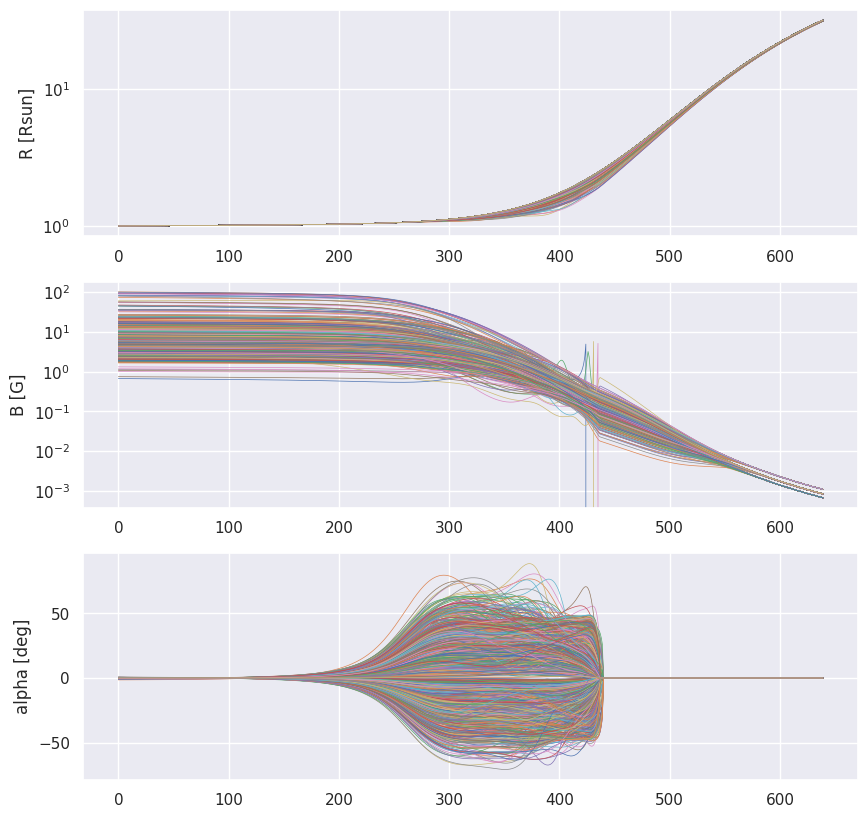

In [5]:
fig, axs = plt.subplots(3, 1, figsize=(10, 10))
for idx, col in enumerate(flow_columns):
    for series in flows_dict.values():
        axs[idx].plot(series.index, series[col], linewidth=0.5)
        
axs[0].set_ylabel('R [Rsun]')
axs[1].set_ylabel('B [G]')
axs[2].set_ylabel('alpha [deg]')

axs[0].set_yscale('log')
axs[1].set_yscale('log')
# axs[2].set_yscale('symlog')


## Scale Inputs

In [6]:
scaled_flows = pd.DataFrame()
scaler = QuantileTransformer(n_quantiles=1000, output_distribution='uniform')

for series in flows_dict.values():
    scaled_flows = pd.concat([scaled_flows, series], axis=0)

scaler.fit(scaled_flows)
scaled_flows = scaler.transform(scaled_flows)


scaled_flows = pd.DataFrame(scaled_flows, columns=flow_columns)
print(scaled_flows.shape)
print(scaled_flows.head())
# scaler.fit(scaled_flows)


(754560, 3)
   R [Rsun]     B [G]  alpha [deg]
0  0.000000  0.951953     0.252764
1  0.002710  0.951928     0.252958
2  0.004004  0.951903     0.253156
3  0.006006  0.951877     0.253420
4  0.007934  0.951852     0.253747


# Magnetic Field - B [G]

In [7]:
# separate into file series
scaled_magnetic = [scaled_flows['B [G]'][i*640 : i*640 + 640] for i in range(len(scaled_flows['B [G]']) // 640)]
scaled_magnetic = np.array(scaled_magnetic)
scaled_magnetic[0][:5]


array([0.95195295, 0.95192808, 0.95190263, 0.95187714, 0.9518516 ])

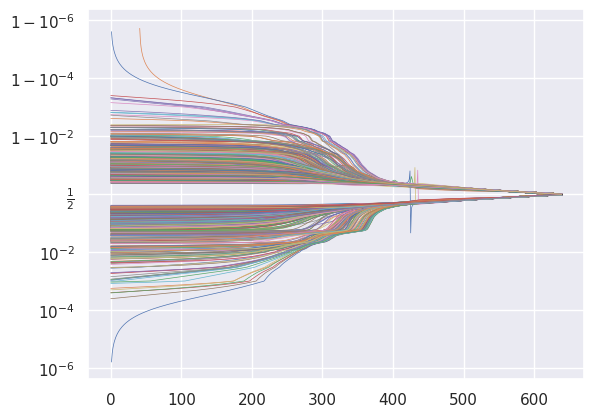

In [8]:
# plot scaled magnetic field
for b_line in scaled_magnetic:
    plt.plot(b_line, linewidth=0.5)

plt.yscale('logit')

## PCA

In [9]:
pca = PCA(n_components=2)
transformed_mag = pca.fit_transform(scaled_magnetic)
transformed_mag

array([[-8.29202527,  0.03913808],
       [-6.67956543, -0.04168524],
       [-5.18142462, -0.51302517],
       ...,
       [-4.38096466, -0.64451635],
       [ 8.38271426, -0.25164323],
       [-8.06265351,  0.00952332]])

/tmp/ipykernel_6906/4113956394.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=transformed_mag[:, 0], y=transformed_mag[:, 1],palette='Set1')


<AxesSubplot: >

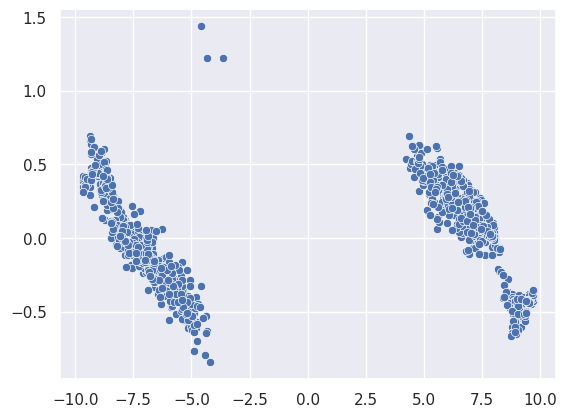

In [10]:
sns.scatterplot(x=transformed_mag[:, 0], y=transformed_mag[:, 1],palette='Set1')

## K-Means

[Text(0.5, 0, 'Number of clusters'),
 Text(0, 0.5, 'Distortion'),
 Text(0.5, 1.0, 'Elbow Plot')]

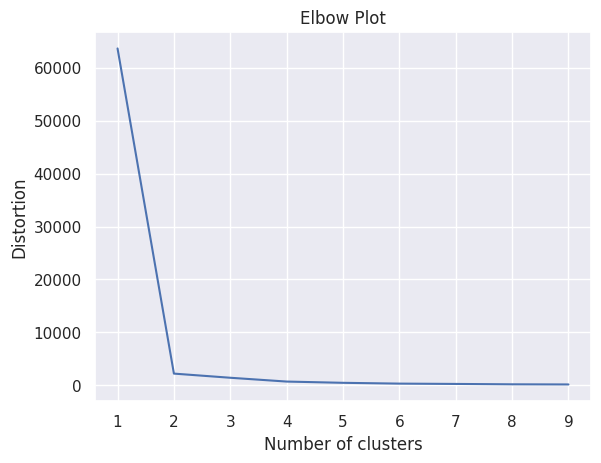

In [11]:
# Elbow Test
distortions = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, max_iter=5000, n_init='auto')
    kmeans.fit(transformed_mag)
    distortions.append(kmeans.inertia_)
    
ep = sns.lineplot(x=K, y=distortions)
ep.set(xlabel='Number of clusters', ylabel='Distortion', title='Elbow Plot')
    

In [12]:
kmeans = KMeans(n_clusters=2,max_iter=5000)

pca_kmeans_mag_labels = kmeans.fit_predict(transformed_mag)

/home/ivsaav/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<AxesSubplot: >

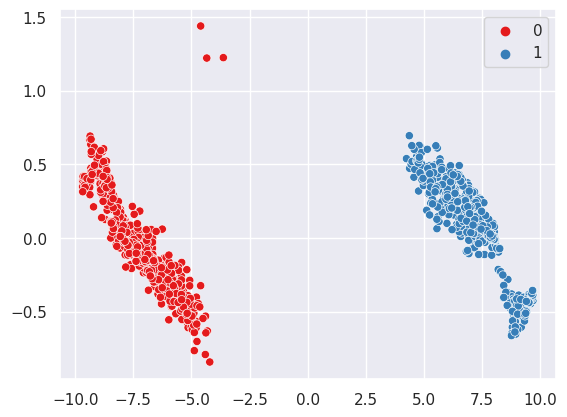

In [13]:
sns.scatterplot(x=transformed_mag[:, 0], y=transformed_mag[:, 1], hue=pca_kmeans_mag_labels, palette='Set1')

### Original Data

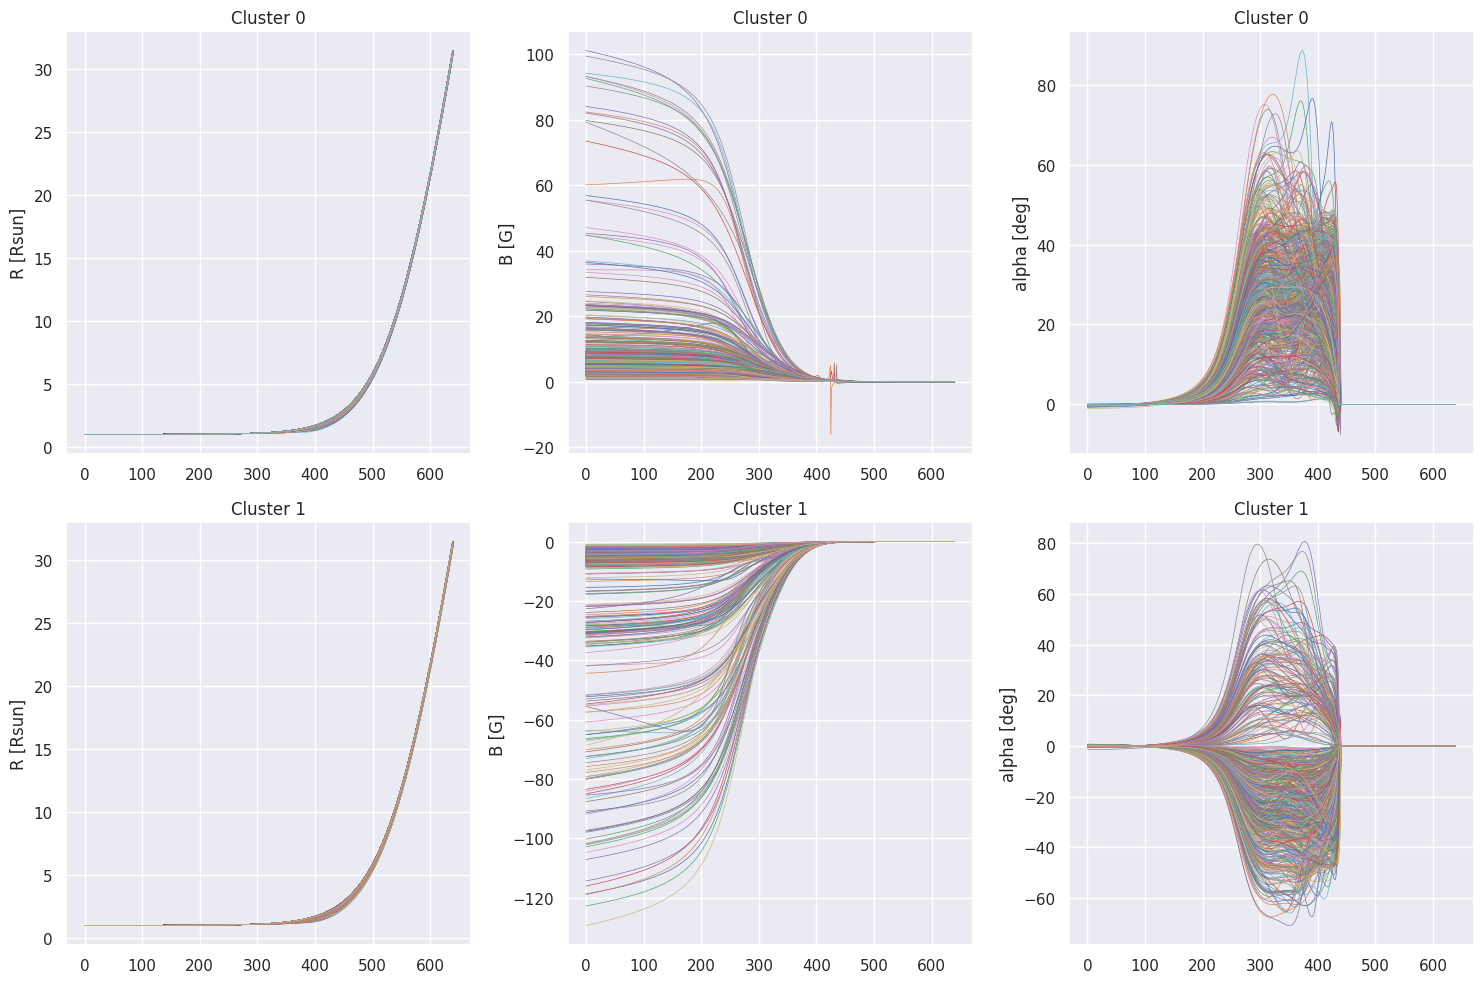

In [14]:
plot_unscaled_clusters(pca_kmeans_mag_labels, 2, flows_dict, flow_columns)

### Cluster Distribution

[Text(0.5, 0, 'Cluster'), Text(0, 0.5, 'Number of files')]

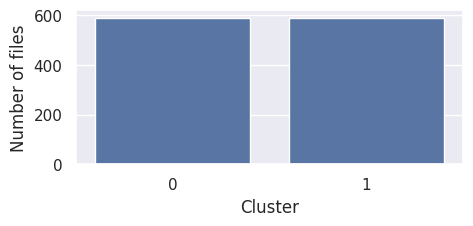

In [15]:
fig, ax = plt.subplots(figsize=(5, 2))
bp = sns.countplot(x=pca_kmeans_mag_labels, ax=ax, color='b')
bp.set(xlabel='Cluster', ylabel='Number of files')

## Hierarchical Clustering

In [56]:
agg = AgglomerativeClustering(compute_distances=True, n_clusters=5, compute_full_tree=True, linkage='average')

agg = agg.fit(transformed_mag)

Text(0.5, 0, 'Number of points in node')

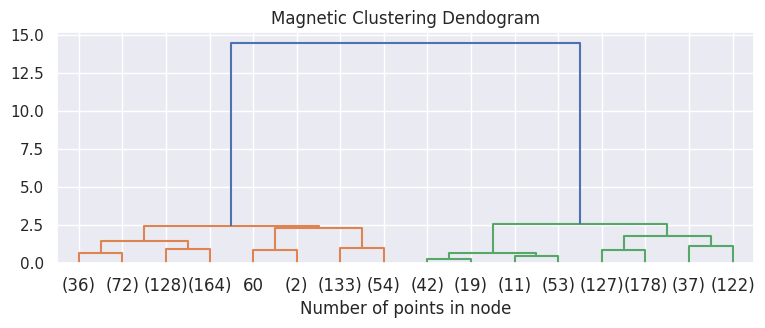

In [59]:
plt.figure(figsize=(9, 3))
plt.title("Magnetic Clustering Dendogram")
plot_dendrogram(agg, truncate_mode='level', p=3)
plt.xlabel("Number of points in node")

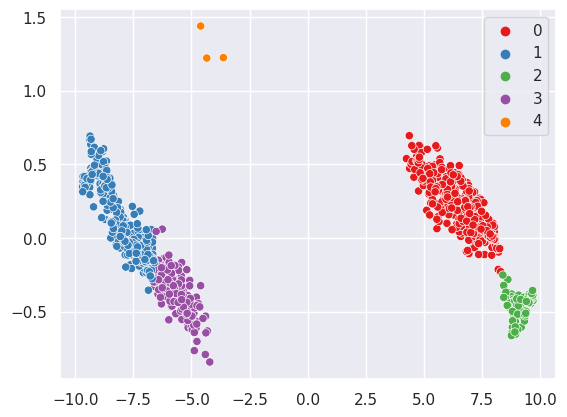

In [60]:
sp = sns.scatterplot(x=transformed_mag[:, 0], y=transformed_mag[:, 1], hue=agg.labels_, palette='Set1')
# sp.legend_.remove()


### Original Data

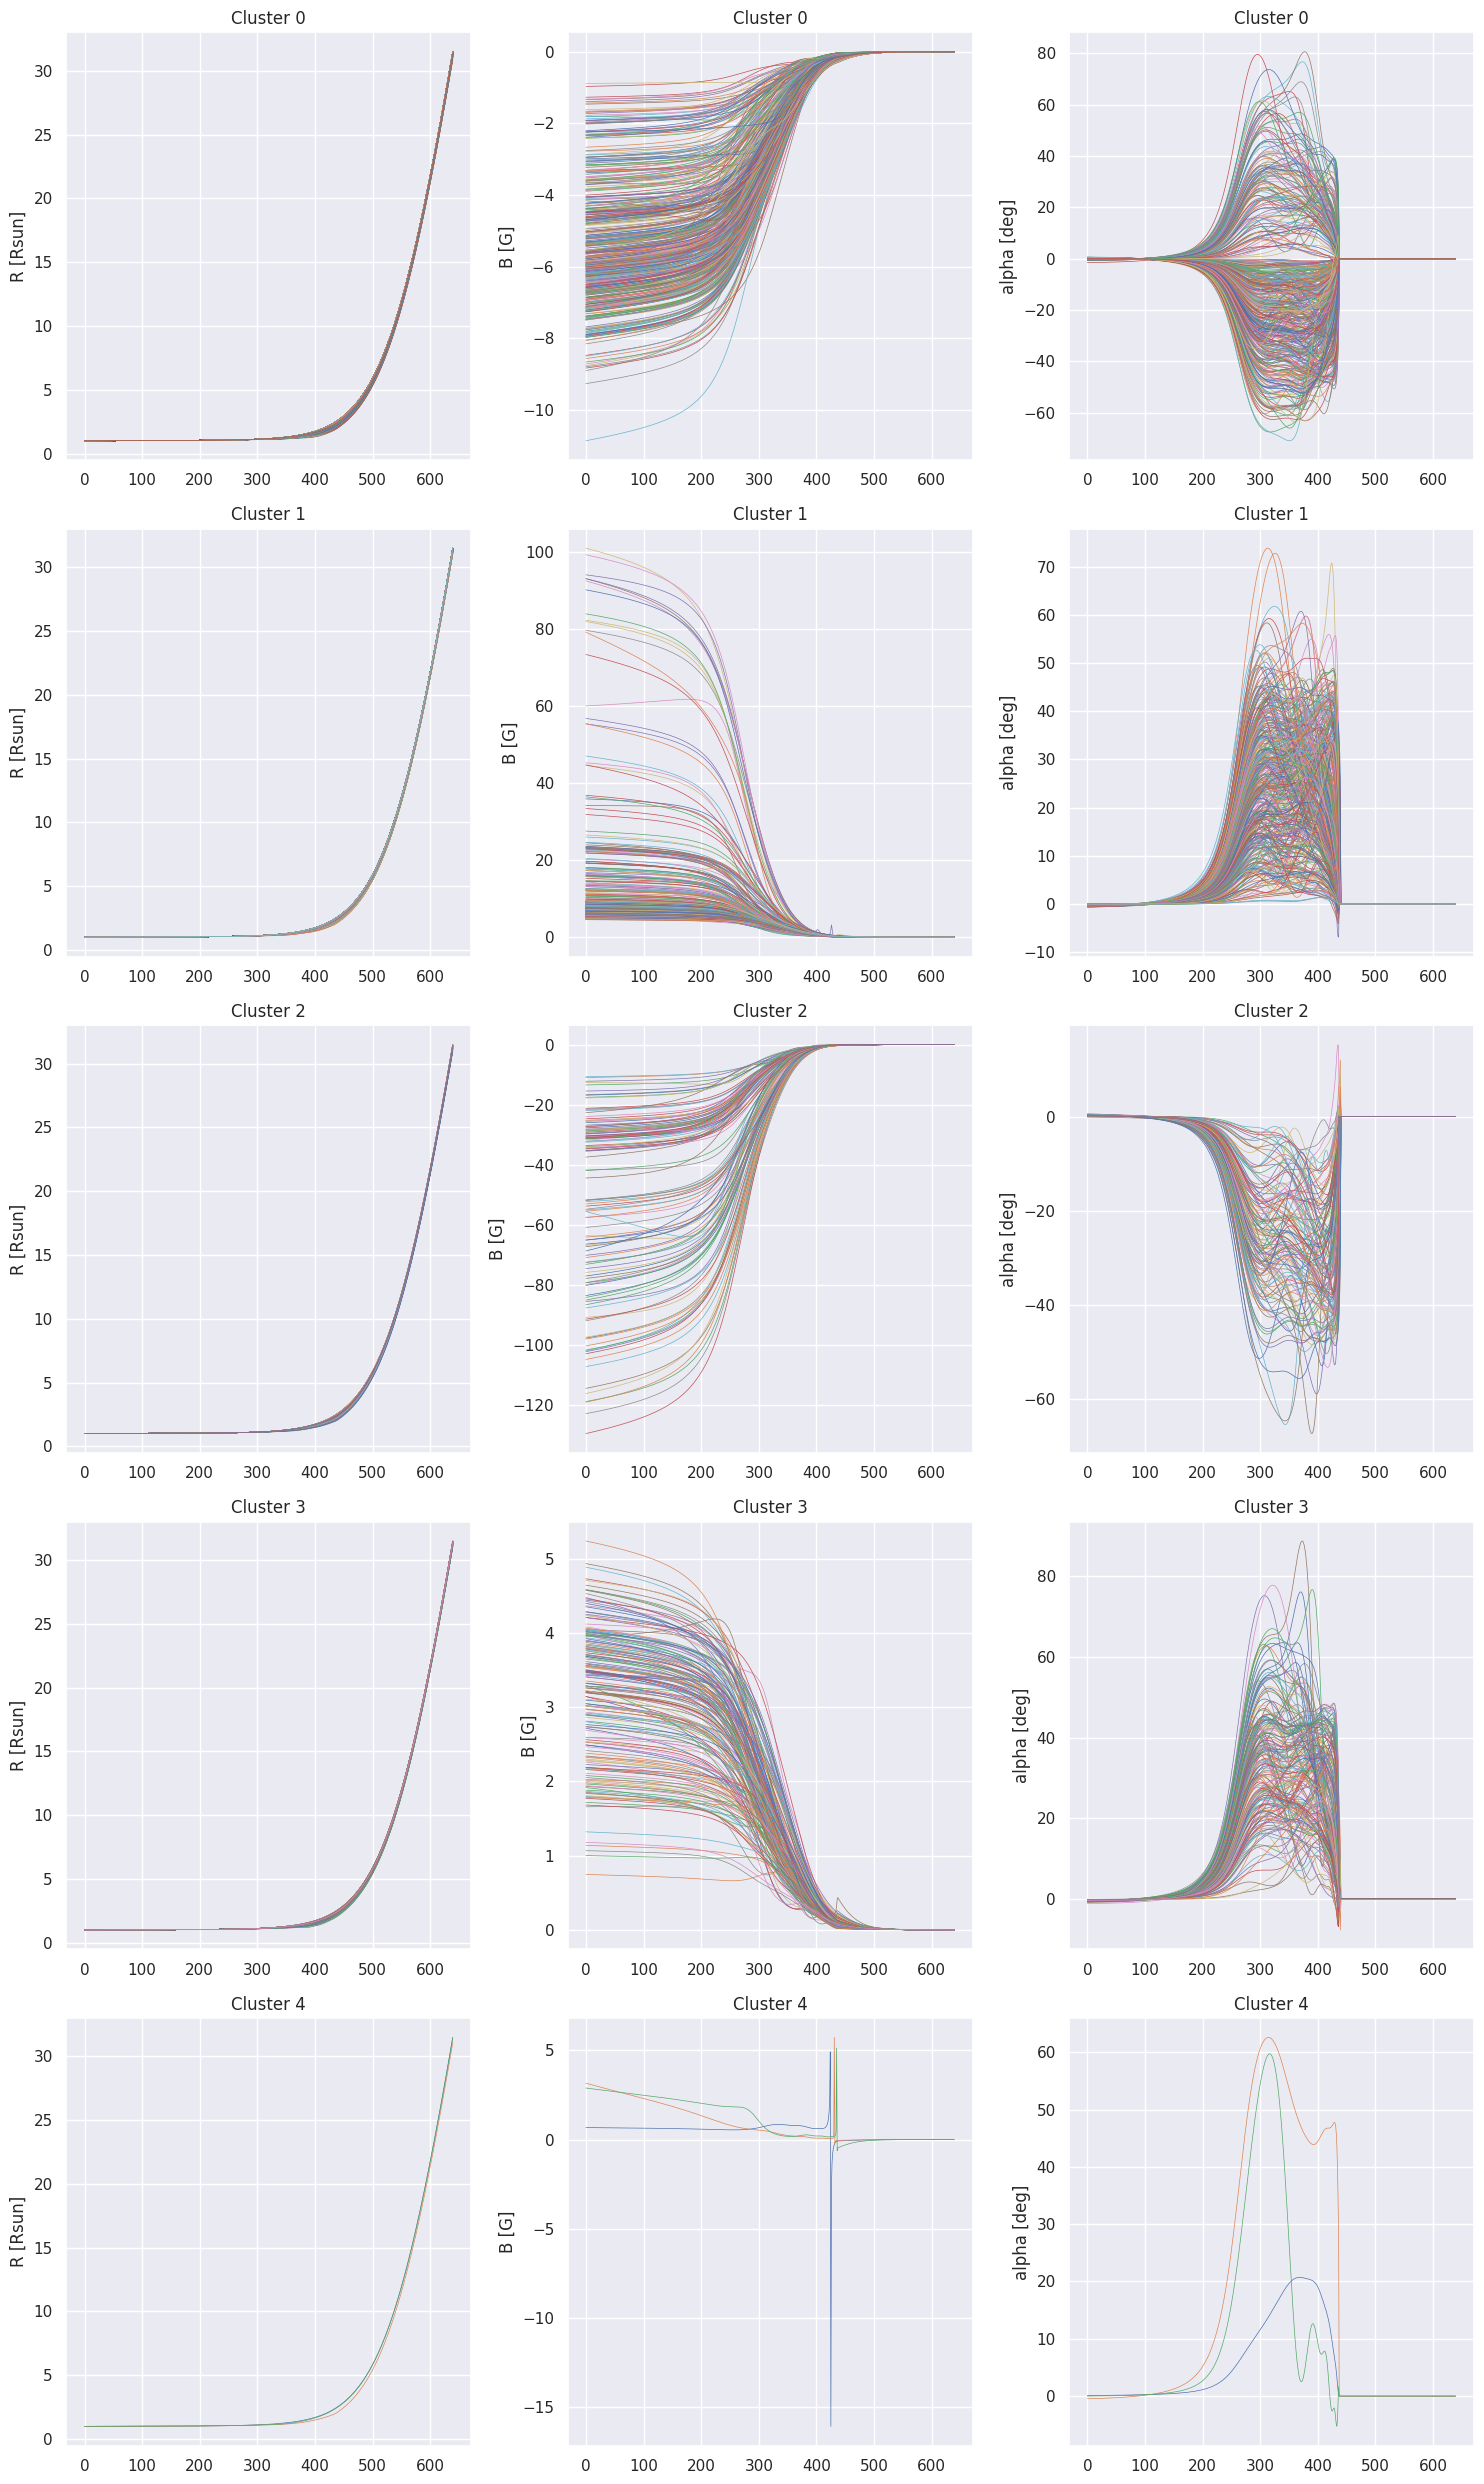

In [61]:
plot_unscaled_clusters(agg.labels_, len(set(agg.labels_)), flows_dict, flow_columns)

In [55]:
# %%capture
# for i in range(2, 10):
#     agg = AgglomerativeClustering(compute_distances=True, n_clusters=i, compute_full_tree=True, linkage='average')
#     agg = agg.fit(transformed_mag)
    
#     sp = sns.scatterplot(x=transformed_mag[:, 0], y=transformed_mag[:, 1], hue=agg.labels_, palette='Set1')
    
#     sub_dir = OUT_DIR / 'mag'
#     if not sub_dir.exists():
#         sub_dir.mkdir()
        
#     plt.savefig(sub_dir / f'hierarch_scatter_{len(set(agg.labels_))}.png', dpi=200)
    
#     plot_unscaled_clusters(agg.labels_, len(set(agg.labels_)), flows_dict, flow_columns, save_path=sub_dir / f'hierarch_{len(set(agg.labels_))}.png') 
    

# Flux Tube Inclination - alpha [deg]

In [68]:
# separate into file series
scaled_alpha = [scaled_flows['alpha [deg]'][i*640 : i*640 + 640] for i in range(len(scaled_flows['alpha [deg]']) // 640)]
scaled_alpha = np.array(scaled_alpha)
scaled_alpha[0][:5]


array([0.24276289, 0.2428977 , 0.24303526, 0.24317562, 0.24332523])

## PCA

In [69]:
pca = PCA(n_components=2)
transformed_alpha = pca.fit_transform(scaled_alpha)
transformed_alpha

array([[-4.54350842,  0.60818047],
       [-6.34322916,  0.80090882],
       [-5.62118711, -0.5606421 ],
       ...,
       [-5.75808223,  1.19993297],
       [ 8.21971863, -0.3513961 ],
       [-2.99824633, -0.87397325]])

### Transformed

<AxesSubplot: >

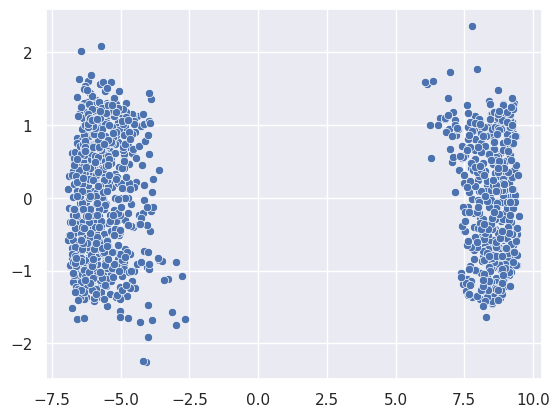

In [70]:
sns.scatterplot(x=transformed_alpha[:, 0], y=transformed_alpha[:, 1])

## K-Means

[Text(0.5, 0, 'Number of clusters'),
 Text(0, 0.5, 'Distortion'),
 Text(0.5, 1.0, 'Elbow Plot')]

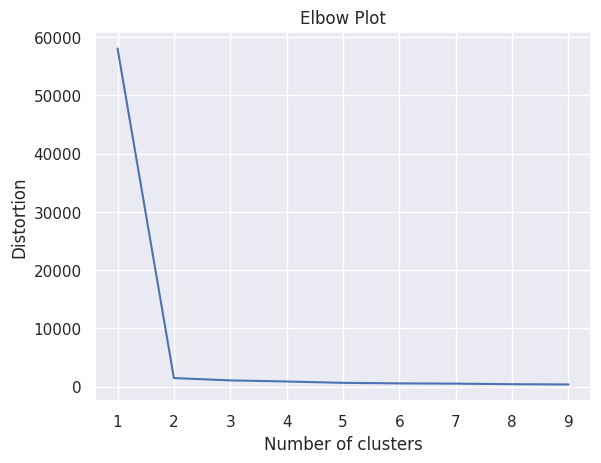

In [71]:
# Elbow Test
distortions = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, max_iter=5000, n_init='auto')
    kmeans.fit(transformed_alpha)
    distortions.append(kmeans.inertia_)
    
ep = sns.lineplot(x=K, y=distortions)
ep.set(xlabel='Number of clusters', ylabel='Distortion', title='Elbow Plot')
    

In [47]:
kmeans = KMeans(n_clusters=2,max_iter=5000)

pca_kmeans_alpha_labels = kmeans.fit_predict(transformed_alpha)

/home/ivsaav/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


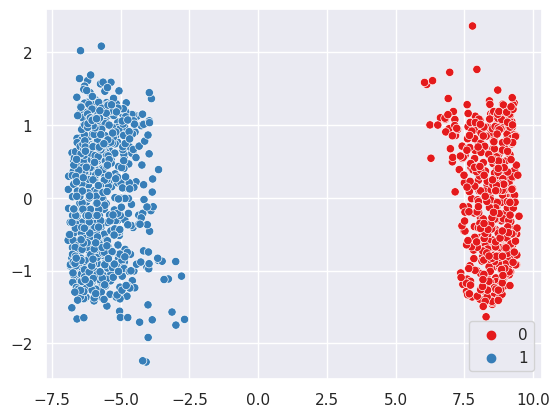

In [51]:
sp = sns.scatterplot(x=transformed_alpha[:, 0], y=transformed_alpha[:, 1], hue=pca_kmeans_alpha_labels, palette='Set1')
plt.legend(loc='lower right')

### Original Data

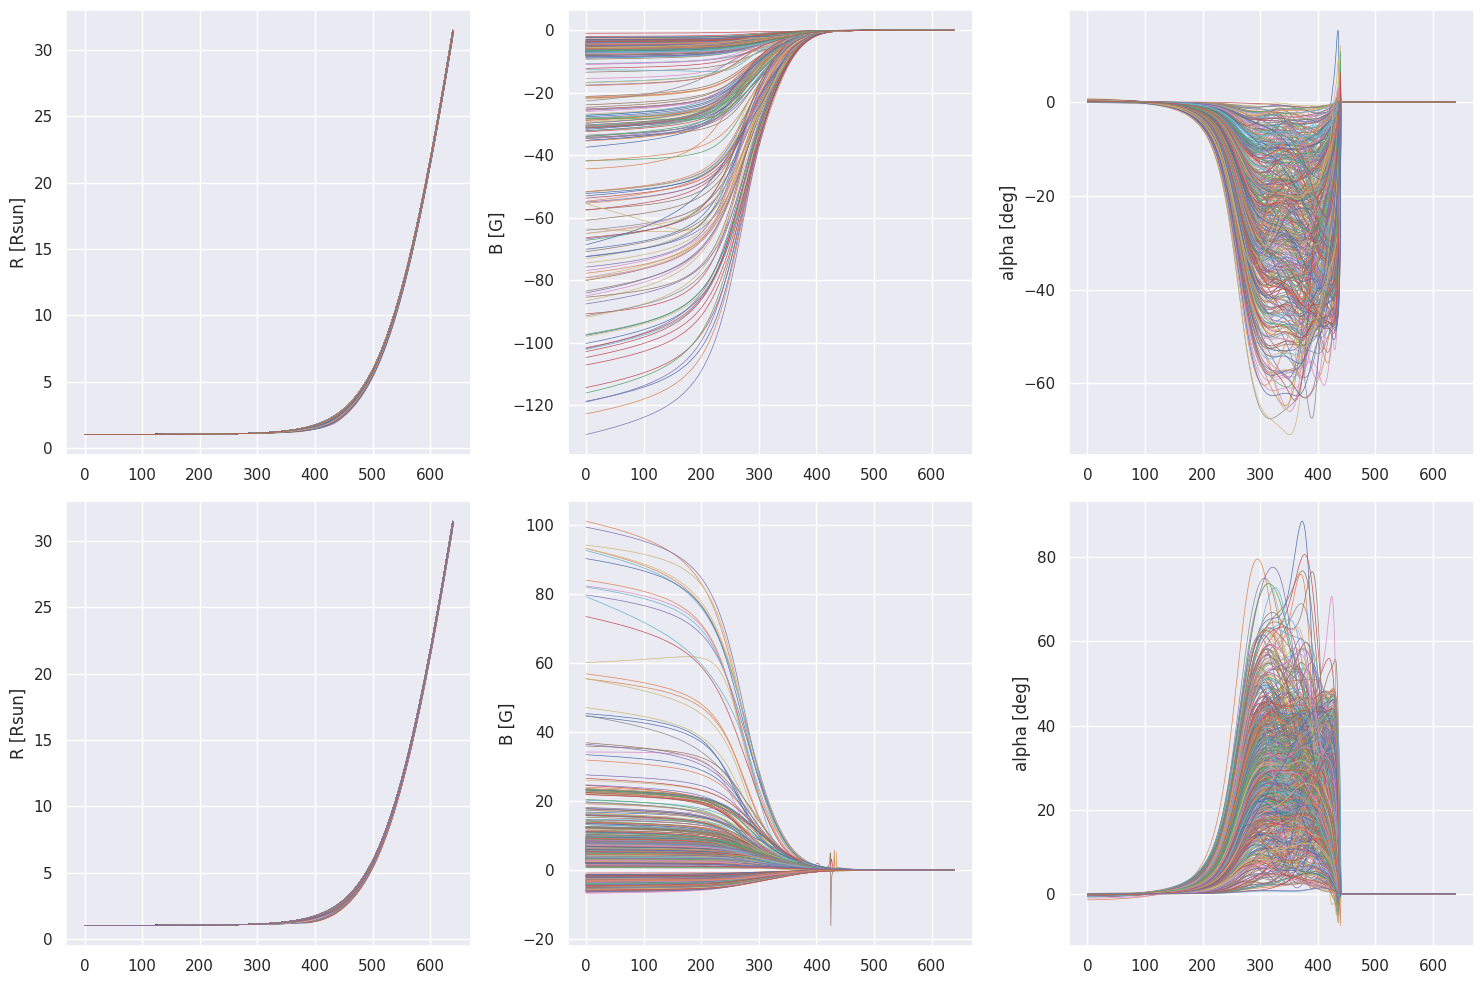

In [48]:
plot_unscaled_clusters(pca_kmeans_alpha_labels, 2, flows_dict, flow_columns)

### Cluster Distribution

[Text(0.5, 0, 'Cluster'), Text(0, 0.5, 'Number of files')]

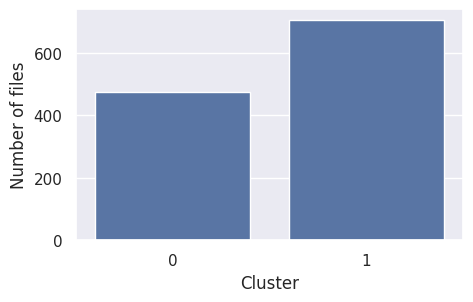

In [56]:
fig, ax = plt.subplots(figsize=(5, 3))
bp = sns.countplot(x=pca_kmeans_alpha_labels, ax=ax, color='b')
bp.set(xlabel='Cluster', ylabel='Number of files')